# SPE FITTING MODULE COMPARISON
This notebook demonstrates how to use 3 different modules (scipy.optimize.curve_fit, symfit and iminuit) to fit the Single Photo-Electron Pulse Area Spectrum.

In [1]:
#%matplotlib inline
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import symfit
import scipy
import iminuit

Populating the interactive namespace from numpy and matplotlib


In [2]:
hist_a = np.array([   6,    6,    5,   13,    4,   10,   20,   62,  276,  889, 1102,
        678,  378,  299,  329,  347,  349,  368,  344,  363,  319,  298,
        291,  260,  268,  212,  204,  203,  190,  161,  153,  143,  129,
        133,  116,   83,  104,   83,   92,   64])
edges_a = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a = (edges_a[1:] + edges_a[:-1]) / 2

In [3]:
hist_a2 = np.array([   1,    3,    7,    5,    3,   10,   18,   69,  302,  982, 1322,
        660,  381,  332,  314,  357,  340,  343,  321,  317,  297,  300,
        303,  246,  224,  230,  200,  203,  182,  152,  164,  153,  105,
        108,  108,   83,  102,   83,   79,   69])
edges_a2 = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a2 = (edges_a2[1:] + edges_a2[:-1]) / 2

In [4]:
hist_a3 = np.array([   4,    2,    4,    5,    9,    8,   20,   76,  298, 1000, 1280,
        709,  393,  341,  328,  330,  352,  334,  348,  317,  328,  280,
        261,  271,  248,  234,  203,  206,  169,  146,  146,  125,  108,
        121,   82,   89,   72,   78,   70,   58])
edges_a3 = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a3 = (edges_a3[1:] + edges_a3[:-1]) / 2

In [5]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

In [6]:
def gaussian_sym(x, a, mu, sigma):
    return a * symfit.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

In [7]:
def mapm_spe_fit(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_):
    """
    Fit for the SPE spectrum of a MAPM

    Parameters
    ----------
    x
    norm : float
        Integral of the zeroth peak in the distribution, represents p(0)
    eped : float
        Distance of the zeroth peak from the origin
    eped_sigma : float
        Sigma of the zeroth peak, represents electronic noise of the system
    spe : float
        Signal produced by 1 photo-electron
    spe_sigma : float
        Spread in the number of photo-electrons incident on the MAPMT
    lambda_ : float
        Poisson mean

    """

    knorm=1.0/np.sqrt(2*3.1415926)

    # Determines kmax, minimum 2, sets up the poisson distribution
    steps = 11
    p = [None] * steps
    p[0] = np.exp(-lambda_)

    for n in range(1, steps):
        p[n] = p[n-1] * lambda_ / n

    # Work out the distribution for 0, then add in the contributions for k=1, k=2...
    eped_sigma2 = eped_sigma**2
    spe_sigma2 = spe_sigma**2
    signal = knorm * norm * p[0] * gaussian(x, 1, eped, eped_sigma) / eped_sigma
    for n in range(1, steps):
        pe = eped + n * spe
        pe_sigma = np.sqrt(n * spe_sigma2 + eped_sigma2)
        signal += knorm * norm * p[n] * gaussian(x, 1, pe, pe_sigma) / pe_sigma

    return signal

In [8]:
def mapm_spe_fit_sym(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_):
    """
    Fit for the SPE spectrum of a MAPM

    Parameters
    ----------
    x
    norm : float
        Integral of the zeroth peak in the distribution, represents p(0)
    eped : float
        Distance of the zeroth peak from the origin
    eped_sigma : float
        Sigma of the zeroth peak, represents electronic noise of the system
    spe : float
        Signal produced by 1 photo-electron
    spe_sigma : float
        Spread in the number of photo-electrons incident on the MAPMT
    lambda_ : float
        Poisson mean

    """

    knorm=1.0/np.sqrt(2*3.1415926)

    # Determines kmax, minimum 2, sets up the poisson distribution
    steps = 11
    p = [None] * steps
    p[0] = symfit.exp(-lambda_)

    for n in range(1, steps):
        p[n] = p[n-1] * lambda_ / n

    # Work out the distribution for 0, then add in the contributions for k=1, k=2...
    eped_sigma2 = eped_sigma**2
    spe_sigma2 = spe_sigma**2
    signal = knorm * norm * p[0] * gaussian_sym(x, 1, eped, eped_sigma) / eped_sigma
    for n in range(1, steps):
        pe = eped + n * spe
        pe_sigma = symfit.sqrt(n * spe_sigma2 + eped_sigma2)
        signal += knorm * norm * p[n] * gaussian_sym(x, 1, pe, pe_sigma) / pe_sigma

    return signal

In [9]:
def mapm_spe_fit_multi(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3):
    l1 = between_a.size
    l2 = between_a2.size
    l3 = between_a3.size
    
    x1 = x[:l1]
    x2 = x[l1:l1+l2]
    x3 = x[l1+l2:l1+l2+l3]
    
    a = np.hstack([mapm_spe_fit(x1, norm, eped, eped_sigma, spe, spe_sigma, lambda_),
                   mapm_spe_fit(x2, norm2, eped, eped_sigma, spe, spe_sigma, lambda_2),
                   mapm_spe_fit(x3, norm3, eped, eped_sigma, spe, spe_sigma, lambda_3)])
    return a

# SciPy curve_fit

## Pros
* No extra dependency
* Simple
* Function based
* Similar to ROOT

## Cons
* Multi-fit is a hack
* Fixed values is a hack
* Only least-squares

### Single Fit

In [10]:
def scipy_fit(x, y):
    p0 = [1000, 0, 5, 20, 5, 1]
    coeff, var_matrix = scipy.optimize.curve_fit(mapm_spe_fit, x, y, p0=p0)
    scipy_y_result = mapm_spe_fit(x, *coeff)
    return scipy_y_result
scipy_y_result = scipy_fit(between_a, hist_a)
scipy_y_result2 = scipy_fit(between_a2, hist_a2)
scipy_y_result3 = scipy_fit(between_a3, hist_a3)
#%timeit scipy_fit(between_a, hist_a)

On my system this fit takes 16 ms to complete

### Multi Fit

In [11]:
x_data = np.hstack([between_a, between_a2, between_a3])
y_data = np.hstack([hist_a, hist_a2, hist_a3])
p0 = [1000, 0, 5, 20, 5, 1, 1000, 1, 1000, 1]
coeff, var_matrix = scipy.optimize.curve_fit(mapm_spe_fit_multi, x_data, y_data, p0=p0)
scipy_y_result_multi_all = mapm_spe_fit_multi(x_data, *coeff)

l1 = between_a.size
l2 = between_a2.size
l3 = between_a3.size

scipy_y_result_multi = scipy_y_result_multi_all[:l1]
scipy_y_result_multi2 = scipy_y_result_multi_all[l1:l1+l2]
scipy_y_result_multi3 = scipy_y_result_multi_all[l1+l2:l1+l2+l3]

# SymFit

## Pros
* Clean
* Multi-fit is a feature
* Fixed values is a feature
* Has other minimizers

## Cons
* Uses symbolic mathematics (creates function once, no interactivity/conditions)

### Single Fit

In [12]:
def symfit_fit(x_in, y_in):
    x, y = symfit.variables('x, y')
    norm, eped, eped_sigma, spe, spe_sigma, lambda_ = symfit.parameters('norm, eped, eped_sigma, spe, spe_sigma, lambda_')
    norm.value = 1000
    eped.value = 0
    eped_sigma.value = 5
    spe.value = 20
    spe_sigma.value = 5
    lambda_.value = 1
    model = {y: mapm_spe_fit_sym(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_)}

    fit = symfit.Fit(model, x=x_in, y=y_in)
    fit_result = fit.execute()
    symfit_y_result = fit.model(x=x_in, **fit_result.params)[0]
    return symfit_y_result
symfit_y_result = symfit_fit(between_a, hist_a)
symfit_y_result2 = symfit_fit(between_a2, hist_a2)
symfit_y_result3 = symfit_fit(between_a3, hist_a3)
#%timeit symfit_fit(between_a, hist_a)

On my system this fit takes 7.5 s to complete

In [13]:
x, y = symfit.variables('x, y')
norm, eped, eped_sigma, spe, spe_sigma, lambda_ = symfit.parameters('norm, eped, eped_sigma, spe, spe_sigma, lambda_')
print("Symbolic Mathematics: \n\n", mapm_spe_fit_sym(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_))

Symbolic Mathematics: 

 1.0993779866734e-7*lambda_**10*norm*exp(-lambda_)*exp(-(-eped - 10*spe + x)**2/(2.0*eped_sigma**2 + 20.0*spe_sigma**2))/sqrt(eped_sigma**2 + 10*spe_sigma**2) + 1.0993779866734e-6*lambda_**9*norm*exp(-lambda_)*exp(-(-eped - 9*spe + x)**2/(2.0*eped_sigma**2 + 18.0*spe_sigma**2))/sqrt(eped_sigma**2 + 9*spe_sigma**2) + 9.8944018800606e-6*lambda_**8*norm*exp(-lambda_)*exp(-(-eped - 8*spe + x)**2/(2.0*eped_sigma**2 + 16.0*spe_sigma**2))/sqrt(eped_sigma**2 + 8*spe_sigma**2) + 7.91552150404848e-5*lambda_**7*norm*exp(-lambda_)*exp(-(-eped - 7*spe + x)**2/(2.0*eped_sigma**2 + 14.0*spe_sigma**2))/sqrt(eped_sigma**2 + 7*spe_sigma**2) + 0.000554086505283394*lambda_**6*norm*exp(-lambda_)*exp(-(-eped - 6*spe + x)**2/(2.0*eped_sigma**2 + 12.0*spe_sigma**2))/sqrt(eped_sigma**2 + 6*spe_sigma**2) + 0.00332451903170036*lambda_**5*norm*exp(-lambda_)*exp(-(-eped - 5*spe + x)**2/(2.0*eped_sigma**2 + 10.0*spe_sigma**2))/sqrt(eped_sigma**2 + 5*spe_sigma**2) + 0.0166225951585018*lambda_

The symbolic mathematics (the fit equation) are printed above.

### Multi Fit

Below is how multi fit in symfit should work, but I cannot get it to work...despite it being the one solution that should have this feature built-in.

In [14]:
"""
x1, x2, x3, y1, y2, y3 = symfit.variables('x1, x2, x3, y1, y2, y3')
norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3 = symfit.parameters('norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3')
norm.value = 10000
eped.value = 0
eped_sigma.value = 5
spe.value = 20
spe_sigma.value = 5
lambda_.value = 1
norm2.value = 10000
lambda_2.value = 1
norm3.value = 10000
lambda_3.value = 1
model = {y1: mapm_spe_fit_sym(x1, norm, eped, eped_sigma, spe, spe_sigma, lambda_),
         y2: mapm_spe_fit_sym(x2, norm2, eped, eped_sigma, spe, spe_sigma, lambda_2),
         y3: mapm_spe_fit_sym(x3, norm3, eped, eped_sigma, spe, spe_sigma, lambda_3)}

fit = symfit.Fit(model, x1=between_a, x2=between_a2, x3=between_a3, y1=hist_a, y2=hist_a2, y3=hist_a3)
fit_result = fit.execute()
symfit_y_result = fit.model(x=between_a, **fit_result.params)
print(symfit_y_result)
"""

"\nx1, x2, x3, y1, y2, y3 = symfit.variables('x1, x2, x3, y1, y2, y3')\nnorm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3 = symfit.parameters('norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3')\nnorm.value = 10000\neped.value = 0\neped_sigma.value = 5\nspe.value = 20\nspe_sigma.value = 5\nlambda_.value = 1\nnorm2.value = 10000\nlambda_2.value = 1\nnorm3.value = 10000\nlambda_3.value = 1\nmodel = {y1: mapm_spe_fit_sym(x1, norm, eped, eped_sigma, spe, spe_sigma, lambda_),\n         y2: mapm_spe_fit_sym(x2, norm2, eped, eped_sigma, spe, spe_sigma, lambda_2),\n         y3: mapm_spe_fit_sym(x3, norm3, eped, eped_sigma, spe, spe_sigma, lambda_3)}\n\nfit = symfit.Fit(model, x1=between_a, x2=between_a2, x3=between_a3, y1=hist_a, y2=hist_a2, y3=hist_a3)\nfit_result = fit.execute()\nsymfit_y_result = fit.model(x=between_a, **fit_result.params)\nprint(symfit_y_result)\n"

# iminuit

## Pros
* Advanced
* Fit diagnosis options
* Fixed values is a feature

## Cons
* Advanced
* Only a minizer - Need to wrap into a fit function
* Multi-fit is a hack (as you have to write your fit function anyway)

In [15]:
from scipy.stats.distributions import poisson
poisson.pmf(6, 2.6)

0.031867055625524499

In [16]:
def iminuit_fit(x, y, **fitargs):
    def minimizeMeSingle(norm, eped, eped_sigma, spe, spe_sigma, lambda_):
        p = mapm_spe_fit(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_)   
        like = -2 * poisson.logpmf(y, p)
        return np.sum(like)    
    m0 = iminuit.Minuit(minimizeMeSingle, print_level=0, pedantic=False, **fitargs)
    return m0
fitargs = dict(norm=1000, eped=0, eped_sigma=5, spe=20, spe_sigma=5, lambda_=1)
m1s = iminuit_fit(between_a, hist_a, **fitargs)
m1s.migrad();
m2s = iminuit_fit(between_a2, hist_a2, **m1s.values)
m2s.migrad();
m3s = iminuit_fit(between_a3, hist_a3, **m1s.values)
m3s.migrad();
iminuit_y_result1 = mapm_spe_fit(between_a, *m1s.args)
iminuit_y_result2 = mapm_spe_fit(between_a2, *m2s.args)
iminuit_y_result3 = mapm_spe_fit(between_a3, *m3s.args)
#%timeit iminuit_fit(between_a, hist_a)
#%timeit m1s.migrad();

On my system this fit takes 60 ms to complete. The actual fit is performed with m.migrad()!

With iminuit we can see the information on the fit:

In [17]:
m1s.print_level = 1
m1s.migrad();

FCN = 377.1162695866486 
 TOTAL NCALL = 390 
 NCALLS = 30 
 
 
 EDM = 4.531307431395347e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,norm,19538.4,206.371,0,0,,,
2,eped,0.65485,0.055013,0,0,,,
3,eped_sigma,2.10198,0.0489386,0,0,,,
4,spe,14.0698,0.251776,0,0,,,
5,spe_sigma,9.88648,0.178948,0,0,,,
6,lambda_,1.31602,0.0232426,0,0,,,


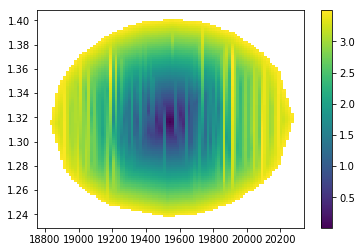

In [18]:
x, y, g, r = m1s.mncontour_grid('norm','lambda_', nsigma=3) # r is the raw data
pcolormesh(x,y,g)
colorbar()

### Multi Fit

In [19]:
x_data = np.hstack([between_a, between_a2, between_a3])
y_data = np.hstack([hist_a, hist_a2, hist_a3])
def minimizeMeMulti(norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3):
    p = mapm_spe_fit_multi(x_data, norm, eped, eped_sigma, spe, spe_sigma, lambda_,  norm2, lambda_2, norm3, lambda_3)   
    like = -2 * poisson.logpmf(y_data, p)
    return np.sum(like)
mm = iminuit.Minuit(minimizeMeMulti, norm=10000, eped=0, eped_sigma=5, spe=20, spe_sigma=5, lambda_=1, norm2=10000, lambda_2=1, norm3=10000, lambda_3=1, print_level=1, pedantic=False)
mm.migrad();
iminuit_y_result_all = mapm_spe_fit_multi(x_data, *mm.args)

l1 = between_a.size
l2 = between_a2.size
l3 = between_a3.size

iminuit_y_result_multi1 = iminuit_y_result_all[:l1]
iminuit_y_result_multi2 = iminuit_y_result_all[l1:l1+l2]
iminuit_y_result_multi3 = iminuit_y_result_all[l1+l2:l1+l2+l3]

FCN = 1182.5274248413984 
 TOTAL NCALL = 282 
 NCALLS = 282 
 
 
 EDM = 4.718484169664488e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,norm,19553.3,144.829,0,0,,,
2,eped,0.608653,0.030102,0,0,,,
3,eped_sigma,2.0685,0.0275903,0,0,,,
4,spe,14.2428,0.147068,0,0,,,
5,spe_sigma,9.85332,0.111176,0,0,,,
6,lambda_,1.31002,0.0178024,0,0,,,
7,norm2,19671.7,143.995,0,0,,,
8,lambda_2,1.21795,0.0161262,0,0,,,
9,norm3,19569.5,147.34,0,0,,,
10,lambda_3,1.18348,0.0157335,0,0,,,


# Plotting

## Single Fit

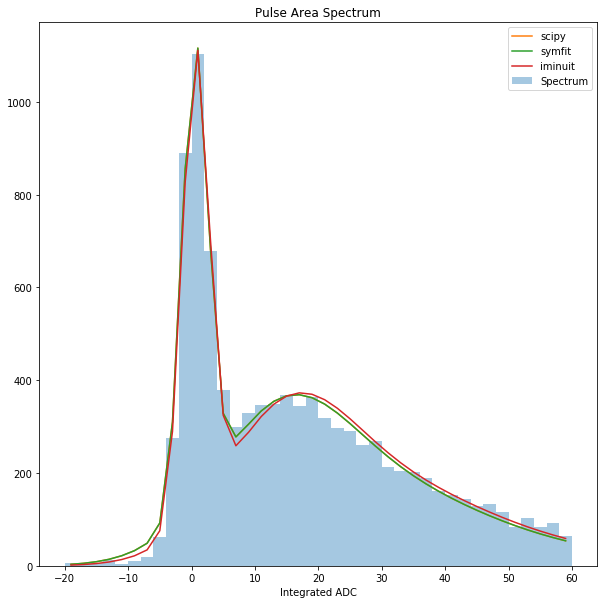

In [20]:
fig = plt.figure(figsize=(10, 10))
ax_a = fig.add_subplot(1, 1, 1)
ax_a.set_title('Pulse Area Spectrum')
ax_a.set_xlabel('Integrated ADC')

ax_a.hist(between_a, edges_a, weights=hist_a, alpha=0.4, label="Spectrum")
ax_a.plot(between_a, scipy_y_result, label="scipy")
ax_a.plot(between_a, symfit_y_result, label="symfit")
ax_a.plot(between_a, iminuit_y_result1, label="iminuit")
ax_a.legend(loc=1)

Iminuit minimizes to a different value than the other fitters (even with identical initial values) as it uses a different method for minimization. Using different starting parameters could result in an identical fit, but it seems to be very difficult to reach the same minima.

## Multi Fit

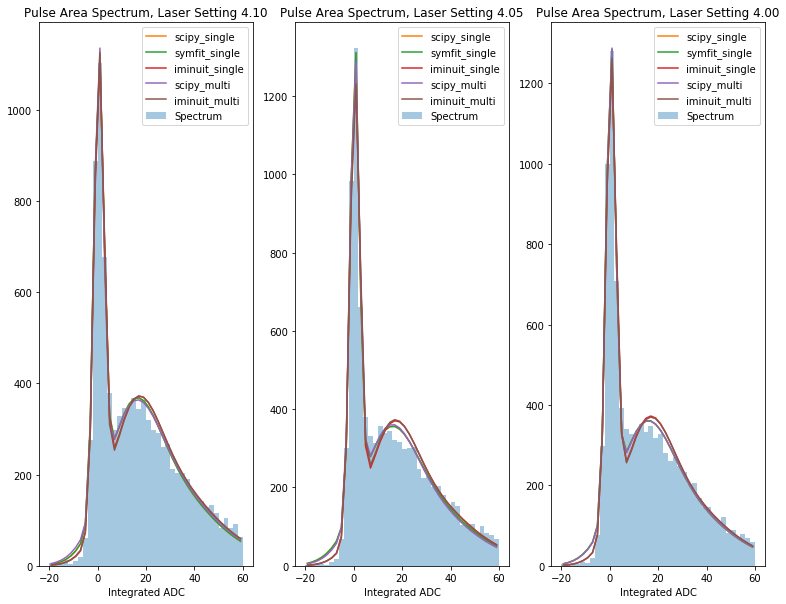

In [21]:
fig_m = plt.figure(figsize=(13, 10))
ax_m1 = fig_m.add_subplot(1, 3, 1)
ax_m1.set_title('Pulse Area Spectrum, Laser Setting 4.10')
ax_m1.set_xlabel('Integrated ADC')
ax_m2 = fig_m.add_subplot(1, 3, 2)
ax_m2.set_title('Pulse Area Spectrum, Laser Setting 4.05')
ax_m2.set_xlabel('Integrated ADC')
ax_m3 = fig_m.add_subplot(1, 3, 3)
ax_m3.set_title('Pulse Area Spectrum, Laser Setting 4.00')
ax_m3.set_xlabel('Integrated ADC')

ax_m1.hist(between_a, edges_a, weights=hist_a, alpha=0.4, label="Spectrum")
ax_m1.plot(between_a, scipy_y_result, label="scipy_single")
ax_m1.plot(between_a, symfit_y_result, label="symfit_single")
ax_m1.plot(between_a, iminuit_y_result1, label="iminuit_single")
ax_m1.plot(between_a, scipy_y_result_multi, label="scipy_multi")
ax_m1.plot(between_a, iminuit_y_result_multi1, label="iminuit_multi")
ax_m1.legend(loc=1)

ax_m2.hist(between_a2, edges_a2, weights=hist_a2, alpha=0.4, label="Spectrum")
ax_m2.plot(between_a2, scipy_y_result2, label="scipy_single")
ax_m2.plot(between_a2, symfit_y_result2, label="symfit_single")
ax_m2.plot(between_a2, iminuit_y_result2, label="iminuit_single")
ax_m2.plot(between_a2, scipy_y_result_multi2, label="scipy_multi")
ax_m2.plot(between_a2, iminuit_y_result_multi2, label="iminuit_multi")
ax_m2.legend(loc=1)

ax_m3.hist(between_a3, edges_a3, weights=hist_a3, alpha=0.4, label="Spectrum")
ax_m3.plot(between_a3, scipy_y_result3, label="scipy_single")
ax_m3.plot(between_a3, symfit_y_result3, label="symfit_single")
ax_m3.plot(between_a3, iminuit_y_result3, label="iminuit_single")
ax_m3.plot(between_a3, scipy_y_result_multi3, label="scipy_multi")
ax_m3.plot(between_a3, iminuit_y_result_multi3, label="iminuit_multi")
ax_m3.legend(loc=1)